In [ ]:
import pandas as pd

# read in excel data
public_data = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/public_data.xlsx')
private_data2123 = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/private_2123.xlsx')
private_data2324 = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/private_2324.xlsx')

private_data2324.head()

private_data2324['Zipcode'] = (
    private_data2324['Location of Private Lateral']
    .str.split(",")
    .str[-1]
    .str.strip()
    .astype(int)
)

# combine old & new private data, change column name to Start_Date for easier merging
private_data = pd.concat([private_data2123, private_data2324])
private_data['lat'] = pd.to_numeric(private_data['lat'])
private_data['long'] = pd.to_numeric(private_data['long'])

private_data.to_csv('../Data/BCW Public and Private Original Data/Public and Private csv/combined_private_data.csv', index=False)

private_data.rename(columns={"Date of WW\nRelease": "Start_Date"}, inplace=True)
private_data.drop('Zipcode', axis=1, inplace=True)

public_data.to_csv('../Data/BCW Public and Private Original Data/Public and Private csv/all_public_data.csv')

private_data.head()
public_data.head()

,SSO_ID,Year,Complete Address,Address,City,State,Zipcode,Flow_Location,Flow Location(Corrected),Gallons,...,Start_Date,Start_Time,End_Date,End_Time,Average_Flow__GPM_,Corrective_Action,Start_Date_Converted,End_Date_Converted,lat,long
0,10424,2021,"8515 HAMMERLY BLVD,Houston,Texas",8515 HAMMERLY BLVD,Houston,Texas,77055.0,Storm Sewer (not contained),Storm Sewer (not contained),157.0,...,2021-04-01,8:35,2021-04-01,11:11,1.0,Cleared Main Line;Cleaned and Disinfected,20210401.0,20210401.0,29.810848,-95.499751
1,10428,2021,"7206 LA PASEO ST,Houston,Texas",7206 LA PASEO ST,Houston,Texas,77087.0,Storm Sewer (not contained),Storm Sewer (not contained),0.0,...,2021-04-01,11:40,2021-04-01,11:40,0.0,Cleared Main Line,20210401.0,20210401.0,29.678630,-95.300138
2,10430,2021,"3502 DARLINGHURST DR,Houston,Texas",3502 DARLINGHURST DR,Houston,Texas,77045.0,Storm Sewer (not contained),Storm Sewer (not contained),166.0,...,2021-04-01,12:25,2021-04-01,13:47,2.0,Cleared Main Line;Cleaned and Disinfected,20210401.0,20210401.0,29.624011,-95.428274
3,10434,2021,"5411 PARDEE ST,Houston,Texas",5411 PARDEE ST,Houston,Texas,77026.0,Bayou/surface water/drainage ditch,Bayou/surface water/drainage ditch,0.0,...,2021-04-01,13:44,2021-04-01,13:44,0.0,Cleared Main Line;Cleaned and Disinfected;Clea...,20210401.0,20210401.0,29.805975,-95.316642
4,10436,2021,"12017 PALMCREST ST,Houston,Texas",12017 PALMCREST ST,Houston,Texas,77034.0,"Contained On Site, not within 5 ft. of Bayou/S...","Contained On Site, not within 5 ft. of Bayou/S...",0.0,...,2021-04-01,14:55,2021-04-01,14:55,0.0,Set Bypass Pump;Cleaned and Disinfected,20210401.0,20210401.0,29.627992,-95.210625


(array([18748., 18871., 18993., 19113., 19236., 19358., 19478., 19601.,
        19723., 19844.]),
 [Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05')])

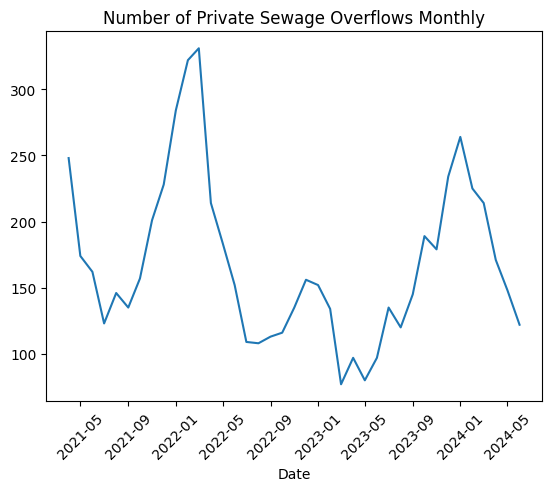

In [2]:
import matplotlib.pyplot as plt
private_data["Month"] = private_data["Start_Date"].dt.to_period("M")

monthly_counts = private_data.groupby("Month").size().reset_index(name = "Sewage Overflows")
monthly_counts.set_index("Month", inplace=True)
monthly_counts.index = monthly_counts.index.to_timestamp()
monthly_counts = monthly_counts.iloc[:-1]

plt.plot(monthly_counts.index, monthly_counts["Sewage Overflows"])
plt.xlabel('Date')
plt.title('Number of Private Sewage Overflows Monthly')
plt.xticks(rotation=45)

In [3]:
from geopy.distance import geodesic

# merge public and private data by date of event
all_data = public_data.merge(private_data, on="Start_Date", suffixes=('_pub', '_priv'))
all_data.dropna(subset=['lat_pub', 'long_pub', 'lat_priv', 'long_priv'], inplace=True)

# function to find event distance using latitude/longitude
def distance(row):
    return geodesic((row['lat_pub'], row['long_pub']), (row['lat_priv'], row['long_priv'])).miles

# apply function to find nearby events
all_data['distance_miles'] = all_data.apply(distance, axis=1)

# filter to keep only private events within 1 mile of a public event
filtered = all_data[all_data['distance_miles'] <= 1]


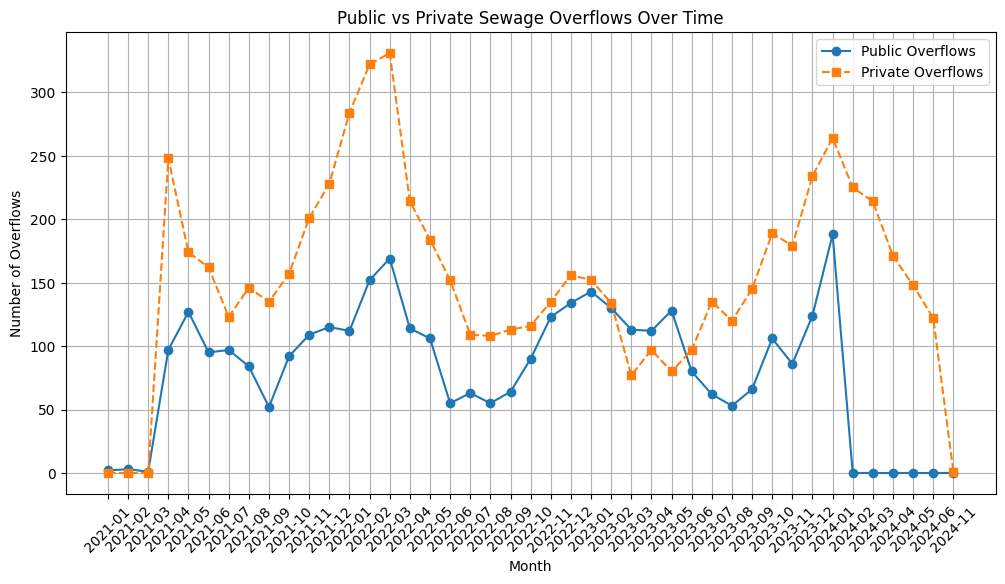

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
public_data = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/public_data.xlsx')
private_data2123 = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/private_2123.xlsx')
private_data2324 = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/private_2324.xlsx')
private_data = pd.concat([private_data2123, private_data2324])

# Convert date columns to datetime format
public_data["Start_Date"] = pd.to_datetime(public_data["Start_Date"], errors='coerce')
private_data["Date of WW\nRelease"] = pd.to_datetime(private_data["Date of WW\nRelease"], errors='coerce')

# Aggregate overflows per month
public_data["Month"] = public_data["Start_Date"].dt.to_period("M")
private_data["Month"] = private_data["Date of WW\nRelease"].dt.to_period("M")

public_counts = public_data.groupby("Month").size().reset_index(name="Public Overflows")
private_counts = private_data.groupby("Month").size().reset_index(name="Private Overflows")

# Merge both datasets for visualization
sewage_counts = pd.merge(public_counts, private_counts, on="Month", how="outer").fillna(0)
sewage_counts["Month"] = sewage_counts["Month"].astype(str)

# Plot public and private sewage overflows over time
plt.figure(figsize=(12, 6))
plt.plot(sewage_counts["Month"], sewage_counts["Public Overflows"], label="Public Overflows", marker='o')
plt.plot(sewage_counts["Month"], sewage_counts["Private Overflows"], label="Private Overflows", marker='s', linestyle="--")
plt.xlabel("Month")
plt.ylabel("Number of Overflows")
plt.title("Public vs Private Sewage Overflows Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()